# Filter analysis of Convolutional Layers

This notebook shows for each Convolutional Layer from a ConvNet trained to classify EEG data into classes of 4 different movements (right hand, left hand, idle, right foot) the on average most active filter.  
Inputs were run through the network and for each filter the 30 inputs which invoked maximum activation for that filter were saved. From those several types of different features are extracted and the distribution of those features is compared to a baseline of randomly sampled control inputs (also belonging to one of the 4 classes.  
The goal is to be able to investigate which features were learned by the different filters.

In [1]:
import numpy as np
import scipy

import logging
log = logging.getLogger()
log.setLevel("DEBUG")
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

from braindecode.veganlasagne.layer_util import print_layers

import os
from numpy.random import RandomState

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5005)
/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import receptive_field
import analysis
import utils

In [4]:
max_baseline_inputs = 1000

In [5]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'
RF_save = receptive_field.ReceptiveFieldInputsIO()

In [6]:
rng = RandomState(98787)

In [7]:
def extract_features_and_diff(X_class,X_baseline,sampling_rate):
    features_class,features_base,feature_labels = extract_features(X_class,X_baseline,sampling_rate)
    
    feat_means = np.mean(features_class,axis=0)
    feat_means_base = np.mean(features_base,axis=0)
    feat_stds = np.std(features_class,axis=0)
    feat_stds_base = np.std(features_class,axis=0)
    #feat_mean_diff = np.abs(np.divide(feat_means-feat_means_base,feat_stds))
    #feat_mean_diff = np.abs(features_base-feat_means).mean(axis=0)
    #feat_mean_diff = np.divide(feat_mean_diff,feat_stds)
    #samples = features_class.shape[0]
    #samples_base = features_base.shape[0]
    #feat_mean_diff = np.divide(feat_means-feat_means_base,np.sqrt(np.square(feat_stds)/samples+np.square(feat_stds_base)/samples_base))
    feat_mean_diff = np.zeros(feat_means.shape)
    feat_p = np.zeros(feat_means.shape)
    for i in range(len(feat_mean_diff)):
        feat_mean_diff[i],feat_p[i] = scipy.stats.ks_2samp(features_class[:,i],features_base[:,i])

    return feat_mean_diff,feat_p,feature_labels,features_class,features_base

def extract_features(X_class,X_baseline,sampling_rate):
    feature_funcs = (analysis.get_frequency,analysis.get_frequency_change,analysis.get_offset,analysis.get_offset_change)

    FFT,FFTc,mean,meanc = utils.get_feature_vals(X_class,feature_funcs,sampling_rate=sampling_rate)
    FFT_base,FFTc_base,mean_base,meanc_base = utils.get_feature_vals(X_baseline,feature_funcs,sampling_rate=sampling_rate)
    
    phase = np.angle(FFT)[:,1:]
    phasec = np.angle(FFTc)[:,1:]
    phase_base = np.angle(FFT_base)[:,1:]
    phasec_base = np.angle(FFTc_base)[:,1:]
    
    FFT = analysis.real_frequency(FFT)
    FFTc = analysis.real_frequency(FFTc)
    FFT_base = analysis.real_frequency(FFT_base)
    FFTc_base = analysis.real_frequency(FFTc_base)
    
    label_FFT = utils.create_feature_index_labels('FFT',FFT.shape[1:])
    label_FFTc = utils.create_feature_index_labels('FFTc',FFTc.shape[1:])
    label_phase = utils.create_feature_index_labels('Phase',phase.shape[1:])
    label_phasec = utils.create_feature_index_labels('Phasec',phasec.shape[1:])
    label_mean = utils.create_feature_index_labels('Mean',mean.shape[1:])
    label_meanc = utils.create_feature_index_labels('Meanc',meanc.shape[1:])
    
    features_class = utils.create_flattened_featurearr([FFT,FFTc,phase,phasec,mean,meanc],shape=(FFT.shape[0],-1))
    features_base = utils.create_flattened_featurearr([FFT_base,FFTc_base,phase_base,phasec_base,mean_base,meanc_base],shape=(FFT_base.shape[0],-1))
    feature_labels = utils.create_flattened_featurearr([label_FFT,label_FFTc,label_phase,label_phasec,label_mean,label_meanc])
    
    return features_class,features_base,feature_labels

In [8]:
def cut_input_data(RF_data,filt,separated_channels=True):
    reshape_channels = n_chans
    if separated_channels:
        reshape_channels = 1
    
    X_RF_cropped = utils.get_cropped_RF(RF_data.results[cl].RF_X,([0],[1],reshape_channels,-1))[filt]
    window_indeces = np.unique(RF_data.results[cl].max_units_in_filters[filt][:,2])
    
    inputs_baseline = RF_data.results[cl].inputs
    X_baseline = utils.cut_ind_windows(inputs_baseline,X_RF_cropped.shape[2],window_indeces).squeeze()
    X_baseline = X_baseline.reshape((-1,X_RF_cropped.shape[1],X_RF_cropped.shape[2]))[:1000]
    np.random.shuffle(X_baseline)
    X_baseline = X_baseline[:max_baseline_inputs]
    
    return X_RF_cropped,X_baseline 
    

def plot_max_filters(RF_data):
    print 'Max filters: ',RF_data.results[cl].max_filters
    plt.figure()
    plt.pcolor(np.reshape(RF_data.results[cl].filters_means,(-1,1)).T)
    plt.colorbar()
    plt.title('Mean activation for feature maps over all inputs')
    plt.show()
    
    
def print_features(score,p,labels,indeces):
    for idx in indeces:
        print 'Score %f  p %f  : %s'%(score[idx],p[idx],labels[idx])
        
        
def plot_RF_starts(RF_data):
    plt.figure()
    sns.distplot(RF_data.results[cl].max_units_in_filters[filt][:,2],bins=np.arange(0,RF_data.results[cl].inputs.shape[2],20),kde=False)
    plt.xlim([0,RF_data.results[cl].inputs.shape[2]])
    plt.title('Starting of the RF windows in complete input signal')
    plt.show()
    
    
def plot_channels(RF_data):
    plt.figure()
    sns.distplot(RF_data.results[cl].max_units_in_filters[filt][:,3],bins=np.arange(n_chans),kde=False)
    plt.xlim([0,n_chans])
    plt.title('Channels that provided maximized input')
    plt.show()
        
        
def plot_channel_avg(X_RF_cropped,channel):
    plt.figure()
    #sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_traces")
    sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_points")
    sns.tsplot(data=X_RF_cropped[:,channel],color='r')
    limits = plt.gca().get_ylim()
    plt.show()
    

def plot_channel_avg_comparison(X1,X2,channel):
    plt.figure()
    #sns.tsplot(data=X_RF_cropped[:,channel],err_style="unit_traces")
    sns.tsplot(data=X1[:,channel],err_style="unit_traces")
    sns.tsplot(data=X2[:,channel],err_style="unit_traces")
    plt.show()
    
    
def plot_dist_comparison(features,features_base,idx):
    sns.distplot(features[:,idx],label='Input')
    sns.distplot(features_base[:,idx],label='Baseline')
    plt.legend()
    plt.xlabel(labels[idx])
    plt.show()
    
    
def subplots_4_features(features,features_base,indeces):
    plt.figure()
    plt.subplot(221)
    plot_dist_comparison(features,features_base,indeces[0])
    plt.subplot(222)
    plot_dist_comparison(features,features_base,indeces[1])
    plt.subplot(223)
    plot_dist_comparison(features,features_base,indeces[2])
    plt.subplot(224)
    plot_dist_comparison(features,features_base,indeces[3])

# Layer 03

In [9]:
filt = 0
filename = 'Layer03_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_03 = RF_save.load(os.path.join(savepath,modelname,filename))

In [10]:
cl = 0
n_chans = RF_data_03.results[cl].n_chans
sampling_rate = RF_data_03.results[cl].sampling_rate
sensor_names = RF_data_03.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_03,filt,separated_channels=True)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [19  5 22 17]


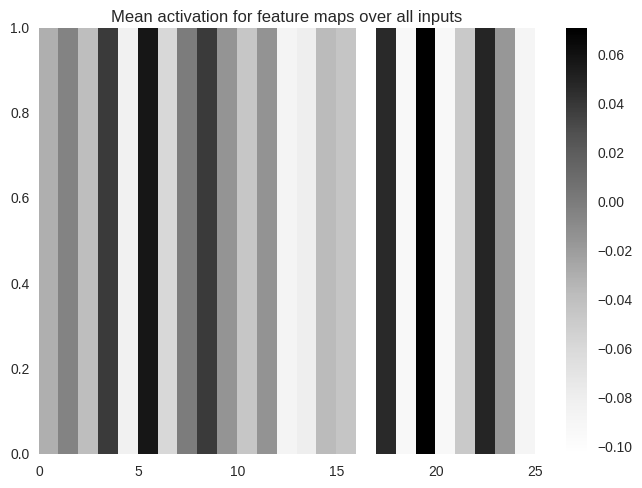

In [11]:
plot_max_filters(RF_data_03)

### Receptive field starting sample
Sample at which the receptive field started in the original input

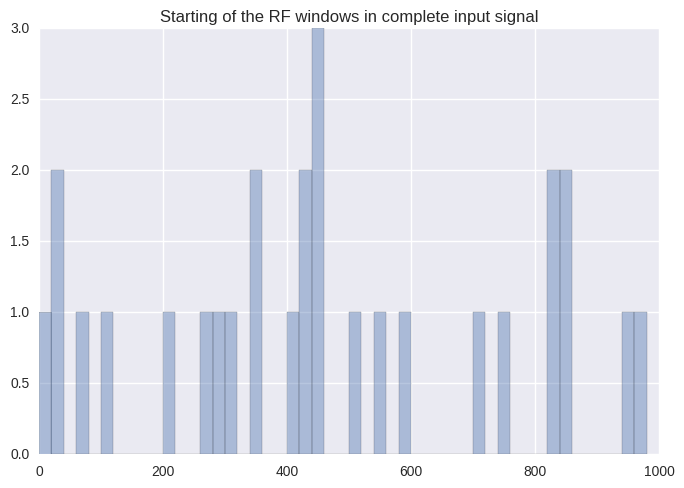

In [12]:
plot_RF_starts(RF_data_03)

### Channels of the Receptive Field
How often specific channels are contributing the highest activating input

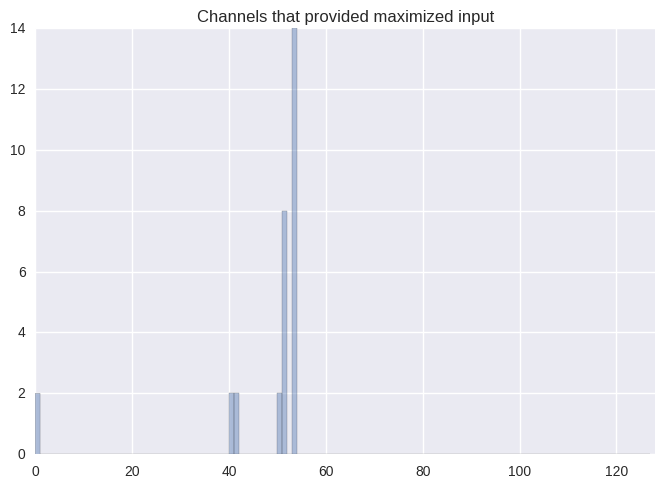

In [13]:
plot_channels(RF_data_03)

### Average input signal

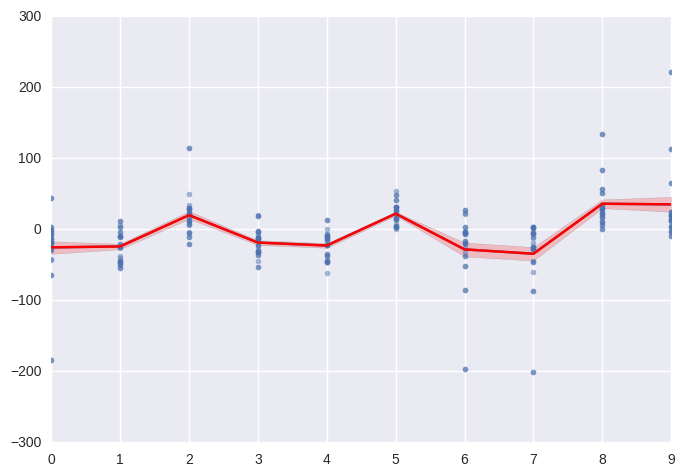

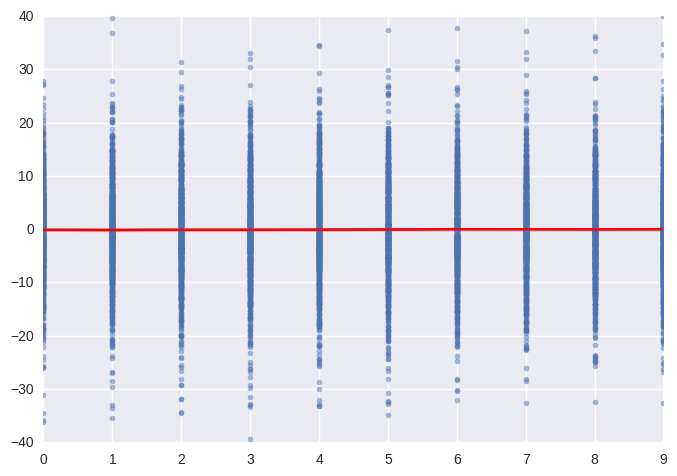

In [14]:
plot_channel_avg(X_RF_cropped,0)
plot_channel_avg(X_baseline,0)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [15]:
feat_mean_diff.shape

(14,)

In [16]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 1.000000  p 0.000000  : FFT 75.0 Fp1
Score 0.995000  p 0.000000  : FFT 100.0 Fp1
Score 0.935000  p 0.000000  : FFTc 25.0 Fp1
Score 0.933667  p 0.000000  : FFT 50.0 Fp1
Score 0.898333  p 0.000000  : FFT 25.0 Fp1
Score 0.707000  p 0.000000  : FFTc 0.0 Fp1
Score 0.692333  p 0.000000  : Meanc Fp1
Score 0.570333  p 0.000000  : Phase 75.0 Fp1
Score 0.535000  p 0.000000  : Phasec 25.0 Fp1
Score 0.358333  p 0.000761  : Mean Fp1
Score 0.273333  p 0.020480  : Phase 100.0 Fp1
Score 0.259000  p 0.032699  : FFT 0.0 Fp1
Score 0.234333  p 0.068960  : Phase 50.0 Fp1
Score 0.234000  p 0.069623  : Phase 25.0 Fp1


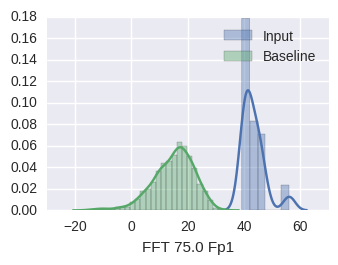

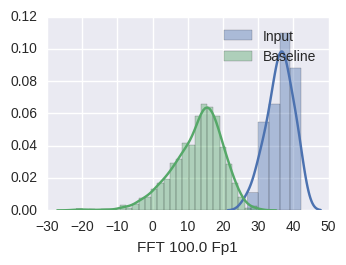

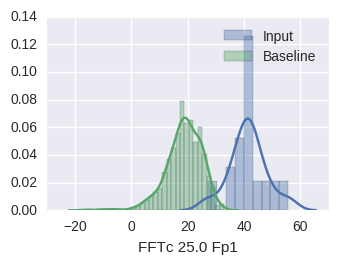

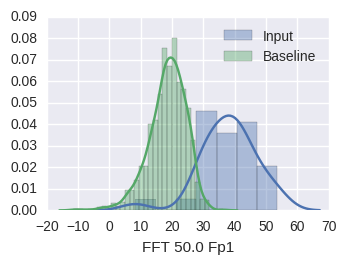

In [17]:
subplots_4_features(features_class,features_base,sort_mean_diff[:5])

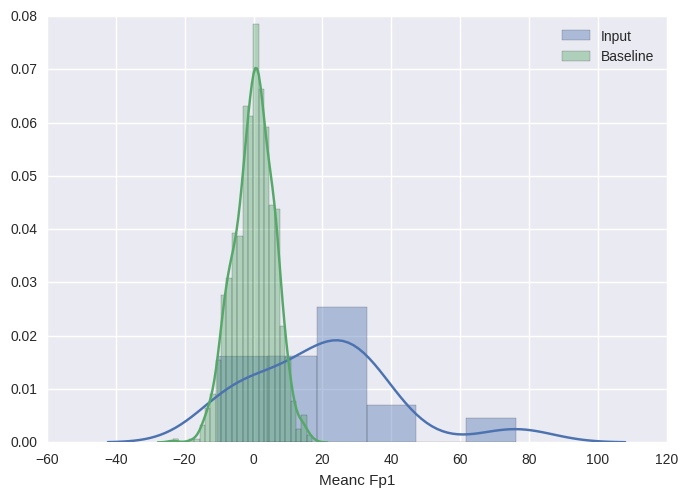

In [18]:
plot_dist_comparison(features_class,features_base,sort_mean_diff[6])

# Layer 05

In [19]:
filt = 0
filename = 'Layer05_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_05 = RF_save.load(os.path.join(savepath,modelname,filename))

In [20]:
cl = 0
n_chans = RF_data_05.results[cl].n_chans
sampling_rate = RF_data_05.results[cl].sampling_rate
sensor_names = RF_data_05.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_05,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [14  8 19  5]


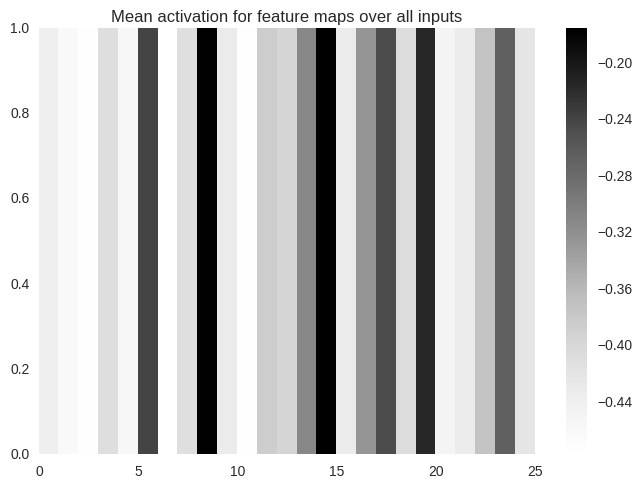

In [21]:
plot_max_filters(RF_data_05)

### Receptive field starting sample
Sample at which the receptive field started in the original input

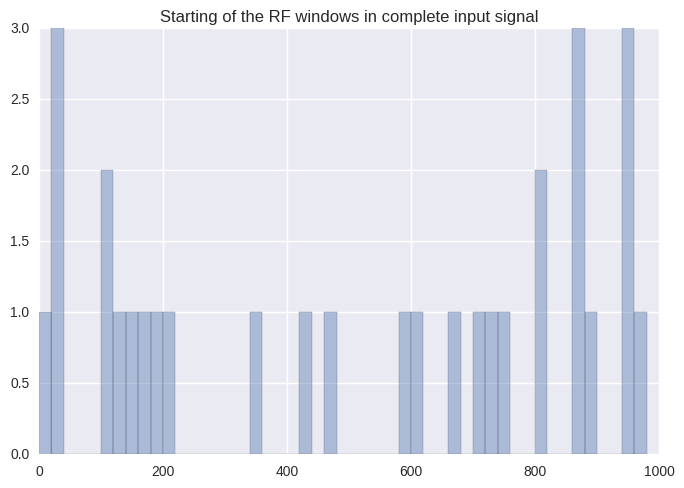

In [22]:
plot_RF_starts(RF_data_05)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [23]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.817000  p 0.000000  : Meanc FC4
Score 0.768667  p 0.000000  : Meanc FCC4h
Score 0.760667  p 0.000000  : Meanc CPP3h
Score 0.758000  p 0.000000  : FFT 50.0 C3
Score 0.740000  p 0.000000  : FFT 50.0 CP5
Score 0.737667  p 0.000000  : FFT 25.0 CPP3h
Score 0.731333  p 0.000000  : FFT 100.0 FCC4h
Score 0.726667  p 0.000000  : Meanc CPP5h
Score 0.726000  p 0.000000  : FFTc 0.0 FC4
Score 0.718000  p 0.000000  : FFT 50.0 CCP3h
Score 0.717667  p 0.000000  : Meanc CP1
Score 0.716667  p 0.000000  : Meanc CCP3h
Score 0.714333  p 0.000000  : FFT 25.0 CCP3h
Score 0.708333  p 0.000000  : Meanc FCC6h
Score 0.705667  p 0.000000  : Meanc P3
Score 0.705667  p 0.000000  : Meanc C3
Score 0.702000  p 0.000000  : FFT 25.0 CP3
Score 0.686000  p 0.000000  : FFT 50.0 CCP5h
Score 0.679667  p 0.000000  : Meanc CP3
Score 0.679000  p 0.000000  : FFT 100.0 FC4


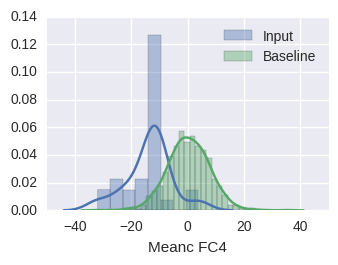

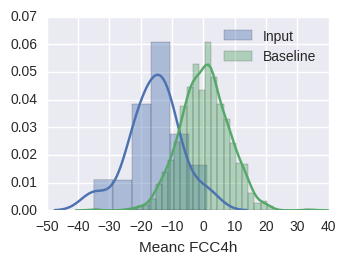

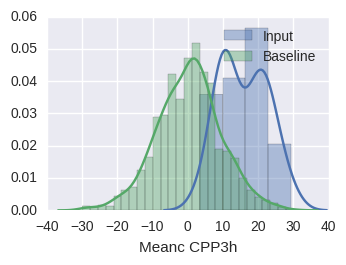

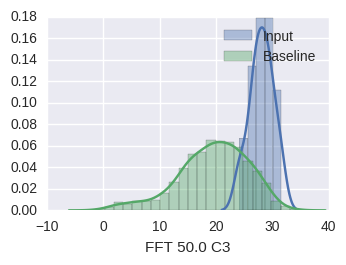

In [24]:
subplots_4_features(features_class,features_base,sort_mean_diff[:5])

In [25]:
print index_labels[sort_mean_diff[:10]]

[['Meanc', [38]] ['Meanc', [48]] ['Meanc', [83]] ['FFT', [2, 55]]
 ['FFT', [2, 72]] ['FFT', [1, 83]] ['FFT', [4, 48]] ['Meanc', [82]]
 ['FFTc', [0, 38]] ['FFT', [2, 65]]]


### Average input signal

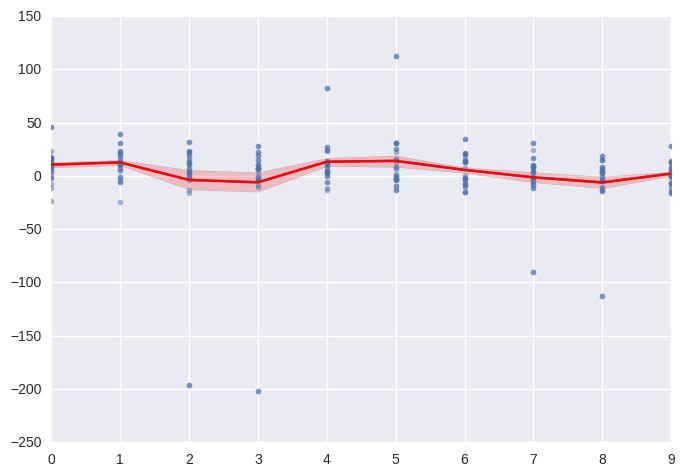

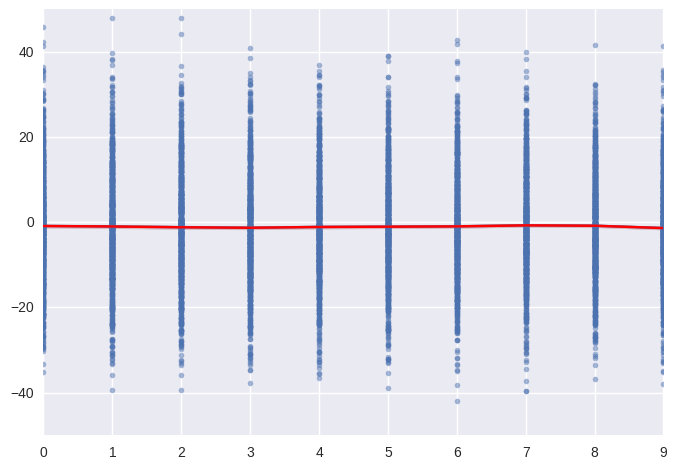

In [26]:
plot_channel_avg(X_RF_cropped,0)
plot_channel_avg(X_baseline,0)

# Layer 11

In [27]:
filename = 'Layer11_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_11 = RF_save.load(os.path.join(savepath,modelname,filename))

In [28]:
cl = 0
filt = 0
n_chans = RF_data_11.results[cl].n_chans
sampling_rate = RF_data_11.results[cl].sampling_rate
sensor_names = RF_data_11.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_11,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [13 31 19 41]


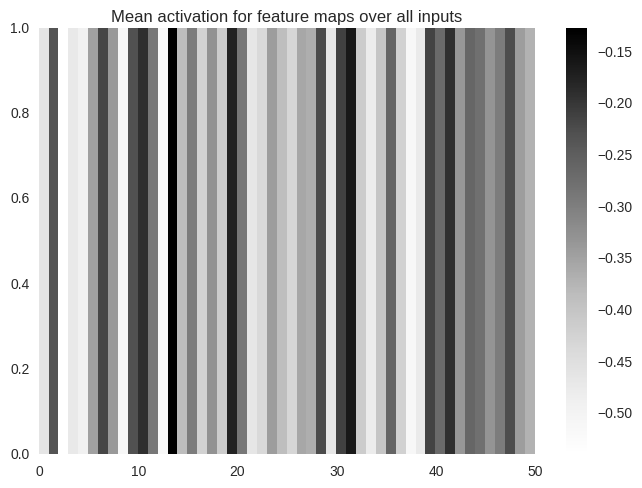

In [29]:
plot_max_filters(RF_data_11)

### Receptive field starting sample
Sample at which the receptive field started in the original input

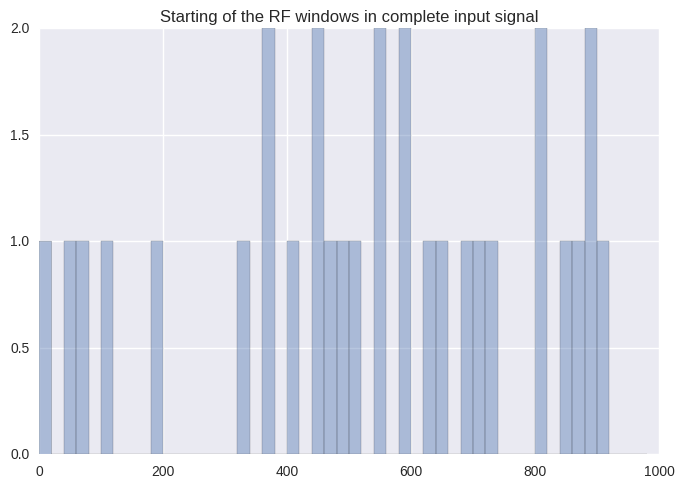

In [30]:
plot_RF_starts(RF_data_11)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [31]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.841000  p 0.000000  : FFT 12.8205128205 C3
Score 0.796333  p 0.000000  : FFT 12.8205128205 CCP3h
Score 0.788667  p 0.000000  : FFT 12.8205128205 FCC3h
Score 0.782667  p 0.000000  : FFT 12.8205128205 FC3
Score 0.767667  p 0.000000  : FFT 12.8205128205 CP3
Score 0.744667  p 0.000000  : Phase 19.2307692308 CCP3h
Score 0.743667  p 0.000000  : FFT 12.8205128205 CCP5h
Score 0.743000  p 0.000000  : Phase 76.9230769231 C1
Score 0.742667  p 0.000000  : Phase 83.3333333333 CCP3h
Score 0.736333  p 0.000000  : FFT 89.7435897436 CCP3h
Score 0.733000  p 0.000000  : Phase 83.3333333333 C3
Score 0.732333  p 0.000000  : Phase 19.2307692308 C3
Score 0.728000  p 0.000000  : Phase 76.9230769231 CCP3h
Score 0.727667  p 0.000000  : FFT 108.974358974 CCP3h
Score 0.726667  p 0.000000  : Phase 19.2307692308 CP3
Score 0.717667  p 0.000000  : FFT 115.384615385 CCP3h
Score 0.706000  p 0.000000  : Phase 12.8205128205 CPP3h
Score 0.696667  p 0.000000  : FFT 76.9230769231 CCP3h
Score 0.694333  p 0.000000  : 

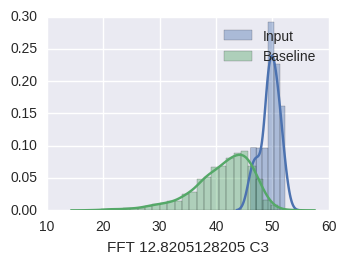

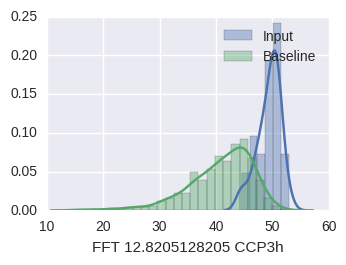

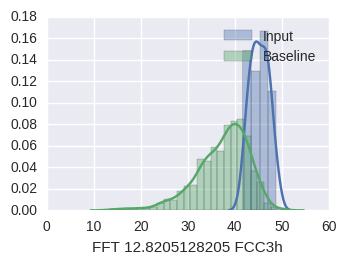

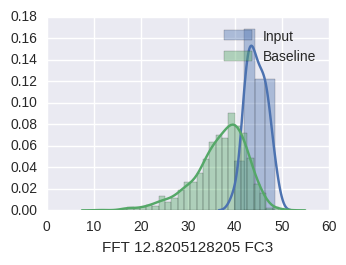

In [32]:
subplots_4_features(features_class,features_base,sort_mean_diff[:5])

In [33]:
print index_labels[sort_mean_diff[:10]]

[['FFT', [2, 55]] ['FFT', [2, 65]] ['FFT', [2, 45]] ['FFT', [2, 34]]
 ['FFT', [2, 73]] ['Phase', [2, 65]] ['FFT', [2, 64]] ['Phase', [11, 56]]
 ['Phase', [12, 65]] ['FFT', [14, 65]]]


### Average input signal

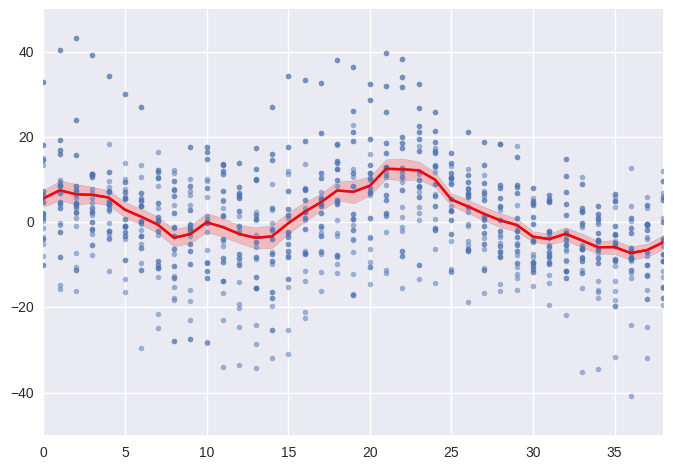

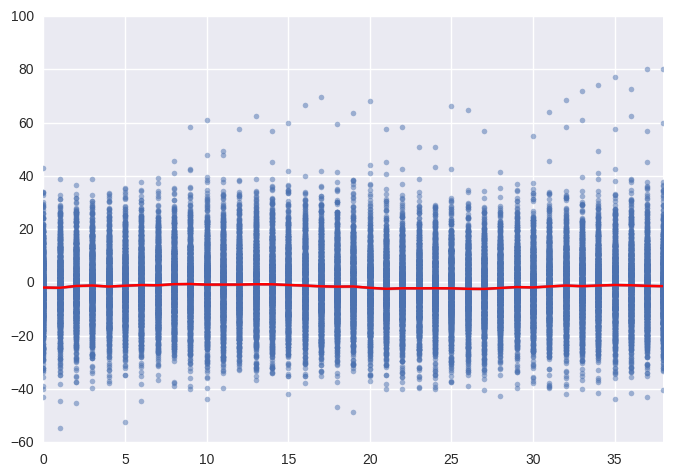

In [34]:
plot_channel_avg(X_RF_cropped,0)
plot_channel_avg(X_baseline,0)

# Layer 17

In [35]:
filt = 0
filename = 'Layer17_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_17 = RF_save.load(os.path.join(savepath,modelname,filename))

In [36]:
cl = 0
n_chans = RF_data_17.results[cl].n_chans
sampling_rate = RF_data_17.results[cl].sampling_rate
sensor_names = RF_data_17.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_17,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [76 88 55 95]


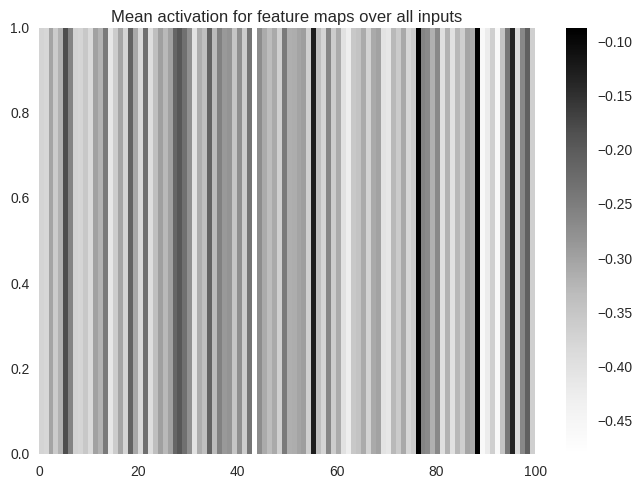

In [37]:
plot_max_filters(RF_data_17)

### Receptive field starting sample
Sample at which the receptive field started in the original input

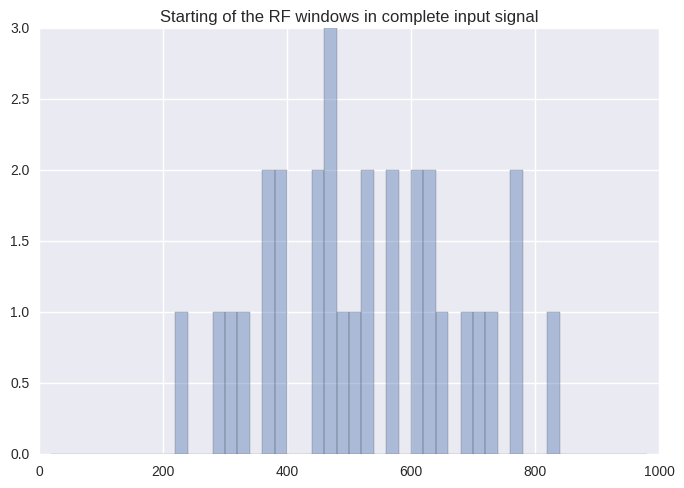

In [38]:
plot_RF_starts(RF_data_17)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [39]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.630333  p 0.000000  : Phase 69.4444444444 PO5
Score 0.588333  p 0.000000  : Phase 69.4444444444 PPO5h
Score 0.584333  p 0.000000  : Phasec 43.6507936508 CCP6h
Score 0.577000  p 0.000000  : FFT 11.9047619048 C3
Score 0.569333  p 0.000000  : Phase 81.3492063492 CPP4h
Score 0.554333  p 0.000000  : Mean Cz
Score 0.545333  p 0.000000  : FFT 11.9047619048 CCP3h
Score 0.544000  p 0.000000  : FFTc 35.7142857143 FCz
Score 0.542333  p 0.000000  : FFT 11.9047619048 CP3
Score 0.535667  p 0.000000  : Phase 9.92063492063 AF7
Score 0.534667  p 0.000000  : FFT 15.873015873 C3
Score 0.532333  p 0.000000  : FFT 35.7142857143 FCC5h
Score 0.531667  p 0.000000  : Phase 9.92063492063 FFC5h
Score 0.528667  p 0.000000  : Meanc P5
Score 0.524667  p 0.000000  : Phase 9.92063492063 F5
Score 0.524333  p 0.000000  : Phase 67.4603174603 FFC5h
Score 0.524000  p 0.000000  : Phase 81.3492063492 POz
Score 0.522667  p 0.000000  : Phase 19.8412698413 PPO9h
Score 0.522333  p 0.000000  : Mean FC2
Score 0.522000  p 

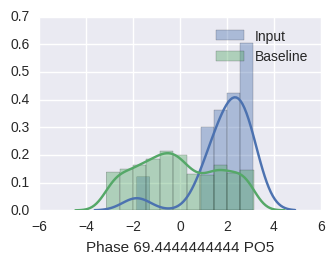

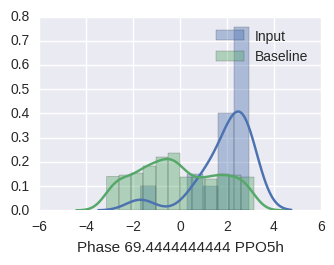

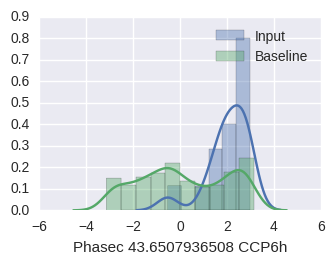

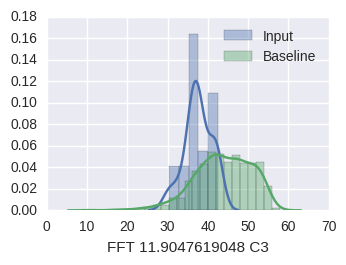

In [40]:
subplots_4_features(features_class,features_base,sort_mean_diff[:5])

In [41]:
print index_labels[sort_mean_diff[:10]]

[['Phase', [34, 109]] ['Phase', [34, 102]] ['Phasec', [21, 69]]
 ['FFT', [6, 55]] ['Phase', [40, 86]] ['Mean', [57]] ['FFT', [6, 65]]
 ['FFTc', [18, 36]] ['FFT', [6, 73]] ['Phase', [4, 5]]]


### Average input signal

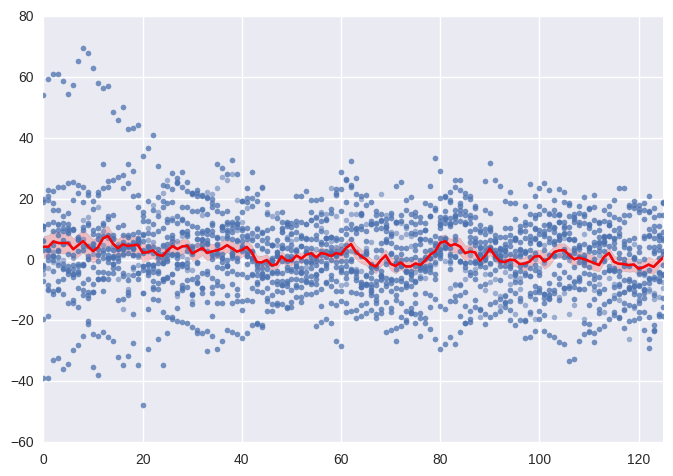

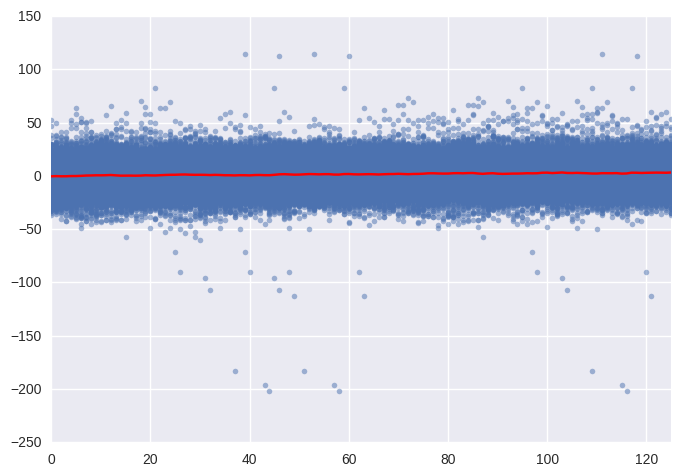

In [42]:
plot_channel_avg(X_RF_cropped,0)
plot_channel_avg(X_baseline,0)

# Layer 23

In [43]:
filt = 0
filename = 'Layer23_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_23 = RF_save.load(os.path.join(savepath,modelname,filename))

In [44]:
cl = 0
n_chans = RF_data_23.results[cl].n_chans
sampling_rate = RF_data_23.results[cl].sampling_rate
sensor_names = RF_data_23.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_23,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [193  50 156  21]


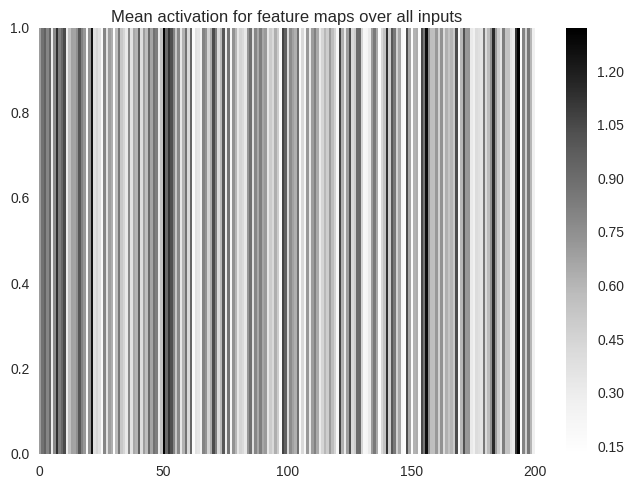

In [45]:
plot_max_filters(RF_data_23)

### Receptive field starting sample
Sample at which the receptive field started in the original input

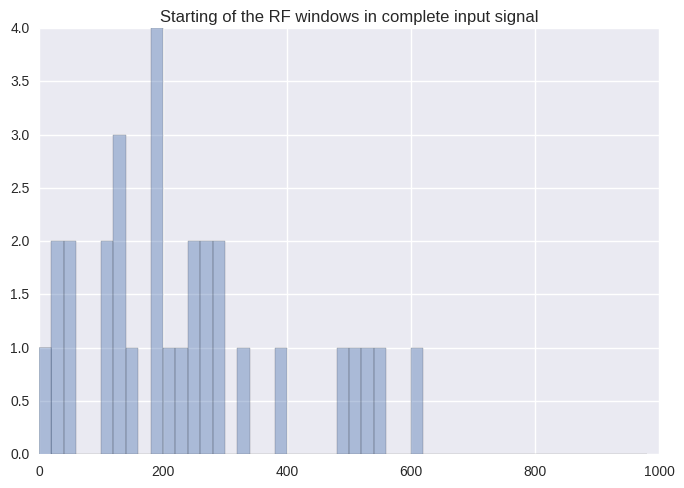

In [46]:
plot_RF_starts(RF_data_23)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [47]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.664333  p 0.000000  : FFTc 5.81395348837 C3
Score 0.628667  p 0.000000  : FFTc 3.87596899225 CP3
Score 0.617667  p 0.000000  : FFT 11.6279069767 FCC3h
Score 0.617000  p 0.000000  : Phase 0.645994832041 AFp4h
Score 0.611667  p 0.000000  : FFT 11.6279069767 FC4
Score 0.610333  p 0.000000  : FFT 11.6279069767 C3
Score 0.610333  p 0.000000  : Phase 0.645994832041 AFz
Score 0.598000  p 0.000000  : Phase 69.1214470284 CP2
Score 0.595333  p 0.000000  : Phasec 0.645994832041 P2
Score 0.588333  p 0.000000  : FFT 10.9819121447 C3
Score 0.586667  p 0.000000  : Phase 0.645994832041 F4
Score 0.583000  p 0.000000  : FFTc 3.87596899225 CPP3h
Score 0.582667  p 0.000000  : FFTc 3.87596899225 CCP5h
Score 0.581667  p 0.000000  : FFT 9.04392764858 C3
Score 0.581667  p 0.000000  : Phasec 30.3617571059 CCP4h
Score 0.581333  p 0.000000  : Phasec 0.645994832041 POz
Score 0.577667  p 0.000000  : FFTc 3.87596899225 CCP3h
Score 0.576667  p 0.000000  : Phase 0.645994832041 FFC2h
Score 0.576333  p 0.000000

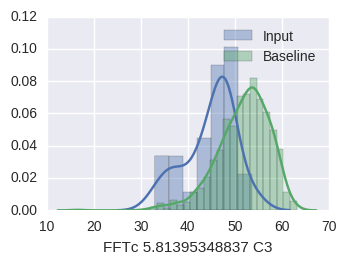

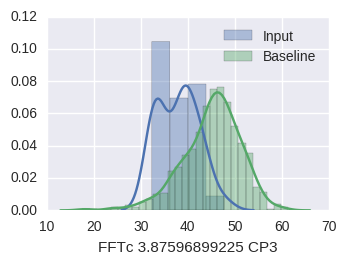

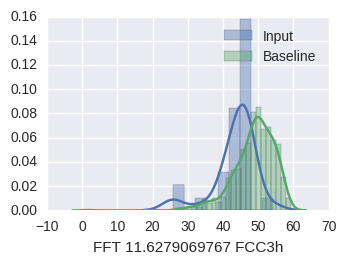

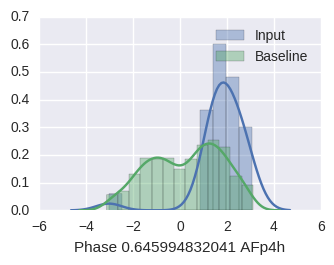

In [48]:
subplots_4_features(features_class,features_base,sort_mean_diff[:5])

In [49]:
print index_labels[sort_mean_diff[:4]]

[['FFTc', [9, 55]] ['FFTc', [6, 73]] ['FFT', [18, 45]] ['Phase', [0, 4]]]


### Average input signal

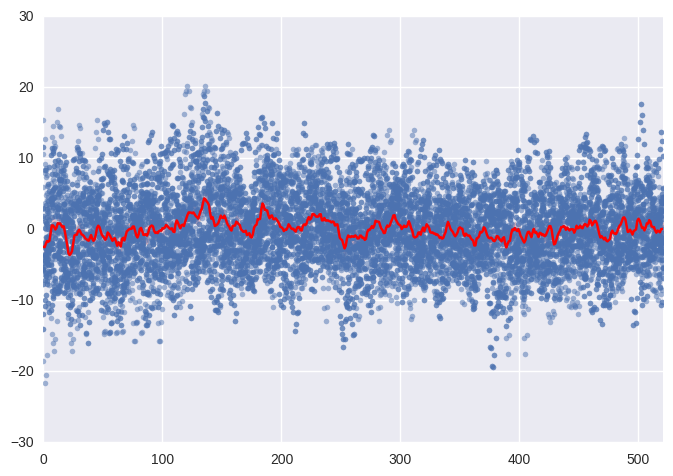

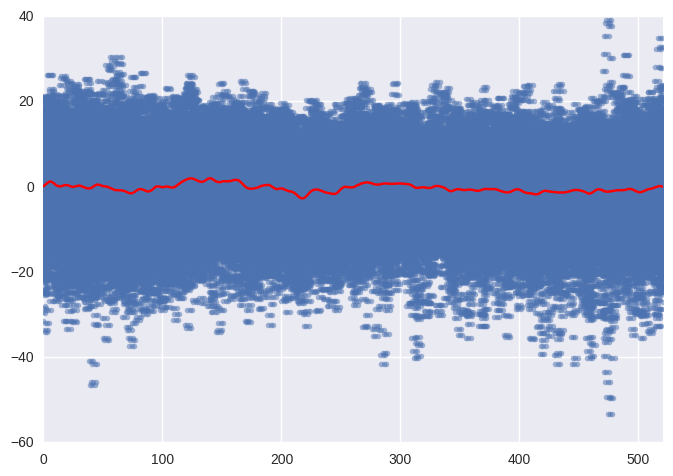

In [60]:
plot_channel_avg(X_RF_cropped,55)
plot_channel_avg(X_baseline,55)

# Layer 28

In [51]:
filename = 'Layer28_nUnits30_nFilters04_firstfiltersoflayer.data'
RF_data_28 = RF_save.load(os.path.join(savepath,modelname,filename))

In [52]:
cl = 0
filt = 2
n_chans = RF_data_28.results[cl].n_chans
sampling_rate = RF_data_28.results[cl].sampling_rate
sensor_names = RF_data_28.results[cl].sensor_names

X_RF_cropped,X_baseline = cut_input_data(RF_data_28,filt,separated_channels=False)
frequencies = scipy.fftpack.fftfreq(X_baseline.shape[2], 1./sampling_rate)
frequencies = frequencies[:frequencies.shape[0]/2].astype(str)

feat_mean_diff,feat_p,index_labels,features_class,features_base = extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
sort_mean_diff = feat_mean_diff.argsort()[::-1]
labels = utils.make_labels_from_index_labels(index_labels.tolist(),
                                    {'FFT':[frequencies,sensor_names],
                                    'FFTc':[frequencies,sensor_names],
                                    'Phase':[frequencies[1:],sensor_names],
                                    'Phasec':[frequencies[1:],sensor_names],
                                    'Mean':[sensor_names],
                                    'Meanc':[sensor_names]})

### Filter activation
Mean activation for each filter in the Layer over all inputs and units

[I,F,U] -> [F]

Max filters are the filters with the highest average activation

Max filters:  [1 2 0 3]


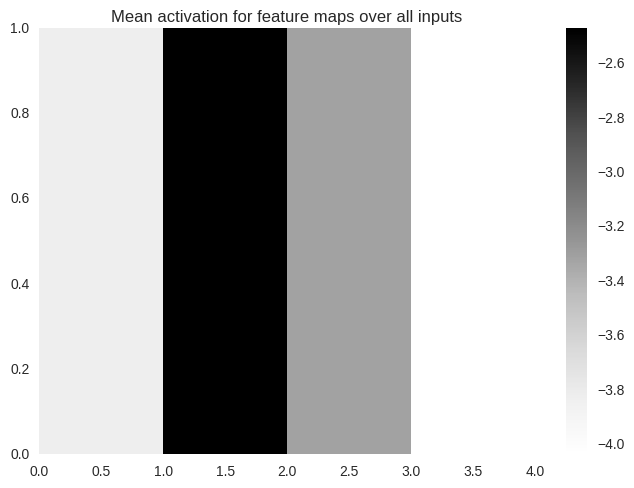

In [53]:
plot_max_filters(RF_data_28)

### Receptive field starting sample
Sample at which the receptive field started in the original input

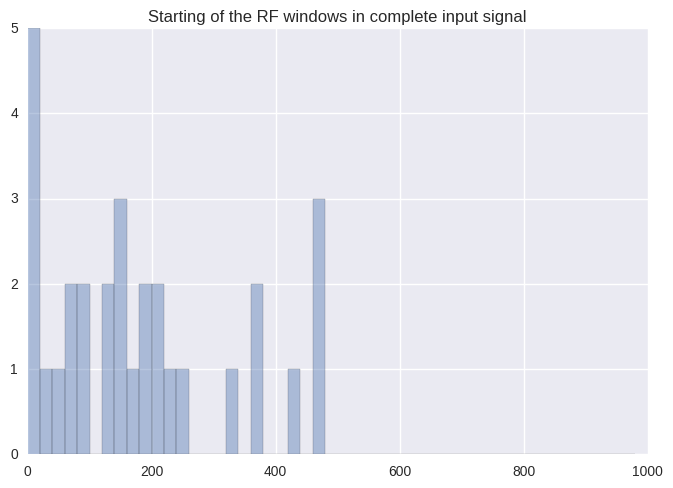

In [54]:
plot_RF_starts(RF_data_28)

### Most differentiating Features
Features that are most distinct between the maximizing input windows and randomly sampled windows of the same size

<b>Score is calculated by</b>

$\frac{mean(X)-mean(X_{base})}{std(X)}$

Labels show type of feature and corresponding Hz or Channel name  
<b>FFT</b>: Frequency Amplitude in Channel  
<b>FFTc</b>: Change of Frequency Amplitude in Channel between first and second half of input window  
<b>Phase</b>: Phase of frequency in Channel  
<b>Phasec</b>: Change of Phase  
<b>Mean</b>: Mean of signal amplitude over complete RF  
<b>Meanc</b>: Change of mean from first to second half of input window  

In [55]:
print_features(feat_mean_diff,feat_p,labels,sort_mean_diff[:20])

Score 0.741667  p 0.000000  : FFT 11.4942528736 C3
Score 0.684667  p 0.000000  : FFT 11.4942528736 CCP5h
Score 0.663000  p 0.000000  : FFT 11.9731800766 C3
Score 0.644333  p 0.000000  : Phasec 0.95785440613 P4
Score 0.632333  p 0.000000  : FFT 11.4942528736 FCC3h
Score 0.623333  p 0.000000  : FFT 12.4521072797 CCP3h
Score 0.621667  p 0.000000  : Phase 0.478927203065 FCz
Score 0.609667  p 0.000000  : Phase 0.478927203065 FCC2h
Score 0.609000  p 0.000000  : FFT 11.9731800766 CCP5h
Score 0.608333  p 0.000000  : Mean Cz
Score 0.601667  p 0.000000  : Mean FC2
Score 0.601667  p 0.000000  : Phase 0.478927203065 FC2
Score 0.589667  p 0.000000  : Mean FCC2h
Score 0.587667  p 0.000000  : FFT 11.9731800766 CCP3h
Score 0.587667  p 0.000000  : Phase 0.478927203065 FCC1h
Score 0.581667  p 0.000000  : FFT 11.4942528736 CCP3h
Score 0.577000  p 0.000000  : FFT 12.4521072797 CP3
Score 0.571333  p 0.000000  : FFT 11.4942528736 FC3
Score 0.571000  p 0.000000  : FFT 9.5785440613 CCP5h
Score 0.569000  p 0.0

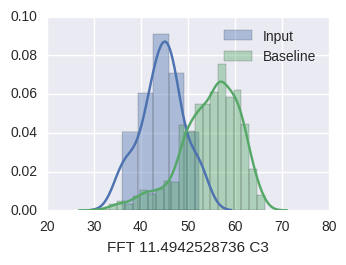

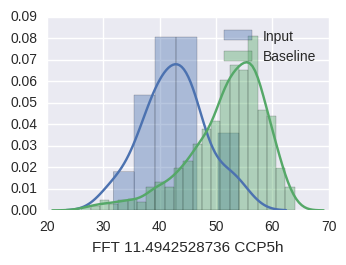

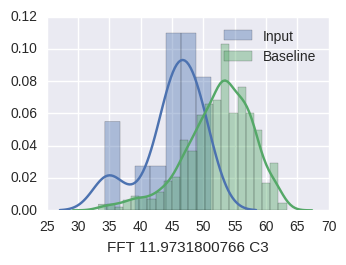

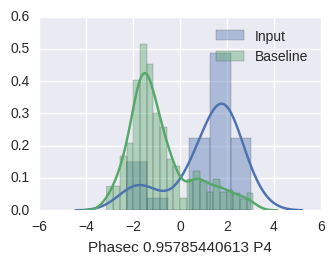

In [56]:
subplots_4_features(features_class,features_base,sort_mean_diff[:5])

In [57]:
print index_labels[sort_mean_diff[:4]]

[['FFT', [24, 55]] ['FFT', [24, 64]] ['FFT', [25, 55]] ['Phasec', [1, 97]]]


### Average input signal

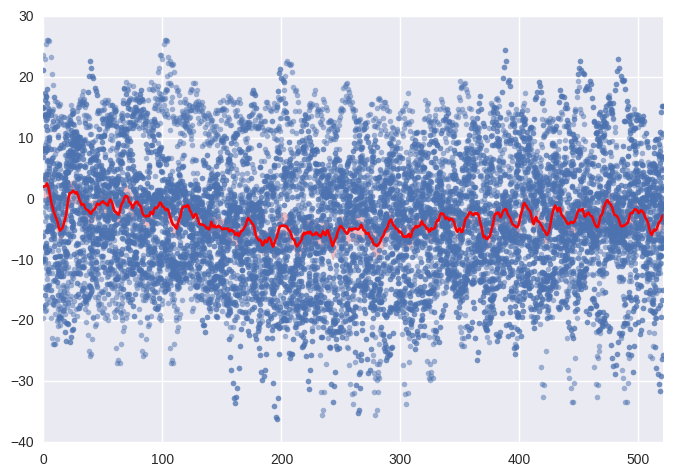

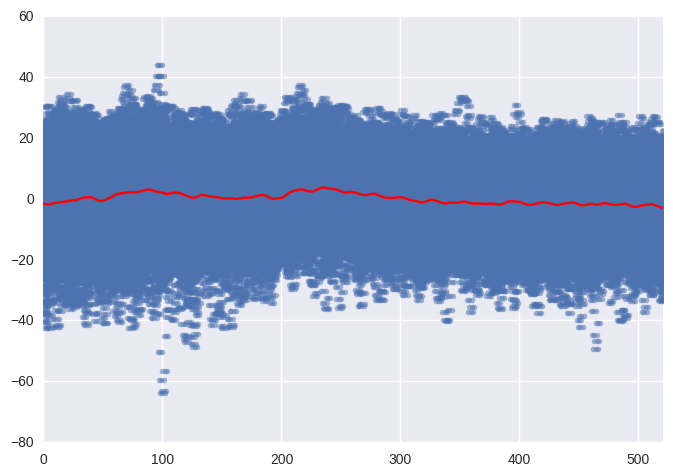

In [59]:
plot_channel_avg(X_RF_cropped,97)
plot_channel_avg(X_baseline,97)